In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import json
import pickle
import itertools
from scipy.signal import savgol_filter

np.random.seed(42)

from formats import experiment_pb2
from formats import  quantification_pb2

from skimage import io
import pandas as pd
import utils


from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset

import umap

import os
import pyro
import pyro.distributions as dist
import pyro.poutine
from pyro.infer import MCMC, NUTS
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide.guides import AutoDiagonalNormal
import pyro.distributions.constraints as constraints
from tqdm import trange

import utils

from importlib import reload
 

/home/austin/.conda/envs/JPLEnv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/austin/.conda/envs/JPLEnv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/austin/.conda/envs/JPLEnv/lib/python3.9/site-packages/umap/distances.py:

In [2]:
local_radius_px = 5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# device =  "cpu" 


In [4]:
import data
reload(data)
from data import PixlMap

 ... Aggregating Quants ...

In [5]:
dataset = PixlMap('089063943')
# dataset = PixlMap('093258245')

data_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=256)


In [6]:
def crop_img(img):
    try:
        indicies = np.where(img)
        non_zero_rows = indicies[0]
        non_zero_cols = indicies[1]
        row1 = min(non_zero_rows)
        row2 = max(non_zero_rows)
        col1 = min(non_zero_cols)
        col2 = max(non_zero_cols)
        crop_img = img[row1:row2, col1:col2]
        return crop_img, row1, row2, col1, col2
    except:
        return img, 0, img.shape[0],0,img.shape[1]

In [7]:
def eval_recon(x_hat,q_hat, x, q):
    x_flat = x.reshape(-1,x.shape[-1])
    x_hat_flat = x_hat.reshape(-1,x.shape[-1])
    x_mean = np.mean(x_flat,0)
    x_ssr = np.sum(np.power(x_flat - x_hat_flat,2))
    x_sst = np.sum(np.power((x_flat - x_mean),2))
    x_r2 = 1 - x_ssr/x_sst

    q_mean = np.mean(q,0)
    q_ssr = np.sum(np.power((q - q_hat),2))
    q_sst = np.sum(np.power((q - q_mean),2))
    q_r2 = 1 - q_ssr/q_sst

    return x_r2.item(),q_r2.item()

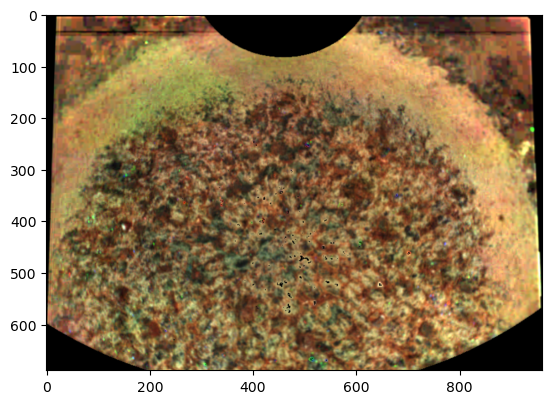

In [8]:
img = dataset.convert_batch_latents_to_image(dataset.convert_to_model_batch()[0]).astype(int)[:,:,0:3]
plt.imshow(crop_img(dataset.rgbu_data.astype(int)[:,:,:3])[0])


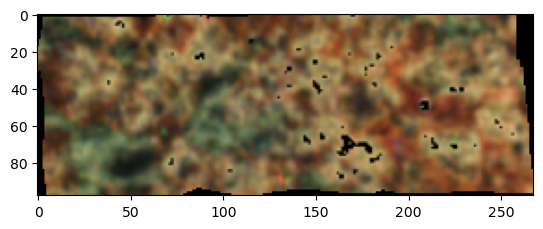

In [9]:
plt.imshow(crop_img(dataset.convert_batch_latents_to_image(dataset.convert_to_model_batch()[0]))[0][:,:,:3].astype(int))


In [10]:
import models
reload(models)
from models import FusionModel, NaiveFusionModel, SeparableVAE, JointVAE

In [11]:
def vis_model(model_path,latent_plots=True):
    model = torch.load(model_path).eval().to(device)    
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        batch_c, batch_z = model.encode(batch_x,batch_q)
        batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())
        z.append(batch_z.detach().cpu())
        x_hat.append(batch_x_hat.detach().cpu())
        q_hat.append(batch_q_hat.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu().numpy()
    q = torch.cat(q,dim=0).detach().cpu().numpy()
    z = torch.cat(z,dim=0).detach().cpu().numpy()
    x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
    q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

    print(eval_recon(x,q,x_hat,q_hat))
    fig, axs = plt.subplots(1,3,figsize=(15,15))
    resid_img = np.sum(np.abs(dataset.convert_batch_latents_to_image(x_hat)-dataset.convert_batch_latents_to_image(x)),axis=-1)
    axs[2].imshow(crop_img(dataset.convert_batch_latents_to_image(x).astype(int)[:,:,:3])[0])
    axs[1].imshow(crop_img(resid_img)[0])
    axs[0].imshow(crop_img(dataset.convert_batch_latents_to_image(x_hat).astype(int)[:,:,:3])[0])
    plt.show()
    
    if latent_plots:
        norm_z = MinMaxScaler().fit_transform(z.reshape(z.shape[0],-1)).reshape(-1,z.shape[-1])
        z_rgb = np.zeros_like(norm_z)
        z_rgb[:,0] = norm_z[:,2]
        z_rgb[:,1] = norm_z[:,1]
        z_rgb[:,2] = norm_z[:,0]

        z_img = z_rgb.reshape(z.shape).astype(float)
        if z.shape[-1] == 3:
            
            z_img = crop_img(dataset.convert_batch_latents_to_image(z_img))[0].astype(float)
            fig, axs = plt.subplots(1,1,figsize=(10,10))
            axs.imshow(z_img)
            plt.show()

In [12]:
def vis_q_model(model_path,latent_plots=True):
    model = torch.load(model_path).eval().to(device)    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//512),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        batch_c, batch_z = model.encode(batch_x,batch_q)
        batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())
        z.append(batch_z.detach().cpu())
        x_hat.append(batch_x_hat.detach().cpu())
        q_hat.append(batch_q_hat.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu().numpy()
    q = torch.cat(q,dim=0).detach().cpu().numpy()
    z = torch.cat(z,dim=0).detach().cpu().numpy()
    x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
    q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

    fig, axs = plt.subplots(1,2,figsize=(15,15))

    cropped_img, min_i, max_i, min_j, max_j = crop_img(dataset.convert_batch_latents_to_image(x).astype(int)[:,:,:3])

    axs[1].imshow(crop_img(dataset.convert_batch_latents_to_image(x_hat).astype(int)[:,:,:3])[0])
    axs[0].imshow(cropped_img)
    plt.show()
    
    fig, axs = plt.subplots(1,1,figsize=(10,10))
    axs.imshow(0.5*(cropped_img/255.0))
    xs = [dataset.pmc_map[pmc]['i']-min_j for pmc in dataset.pmc]
    ys = [dataset.pmc_map[pmc]['j']-min_i for pmc in dataset.pmc]
    norm_z = MinMaxScaler().fit_transform(z).astype(float)
    axs.scatter(xs,ys,alpha=0.95,c=norm_z,s=7.5)


(0.9314119443297386, 0.9726770874112844)


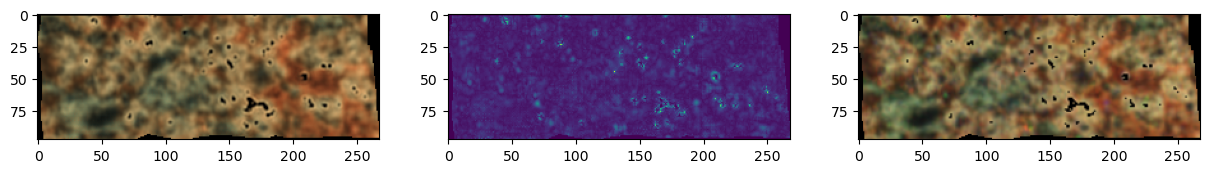

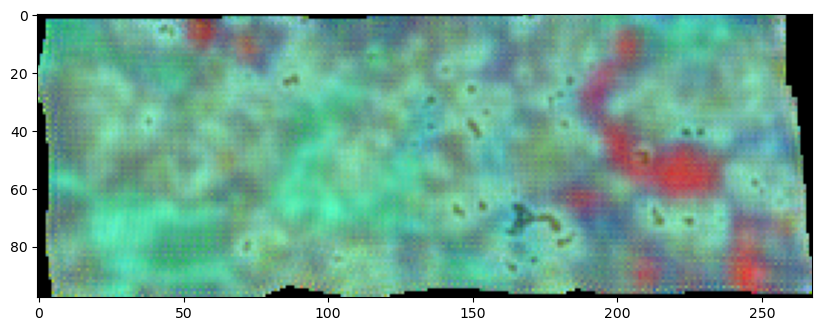

In [13]:
vis_model(f'models-tmp/FusionModel-z-3-c-1-h-64-d-16-r-5.pt')

(0.9355214610695839, 0.9877711096778512)


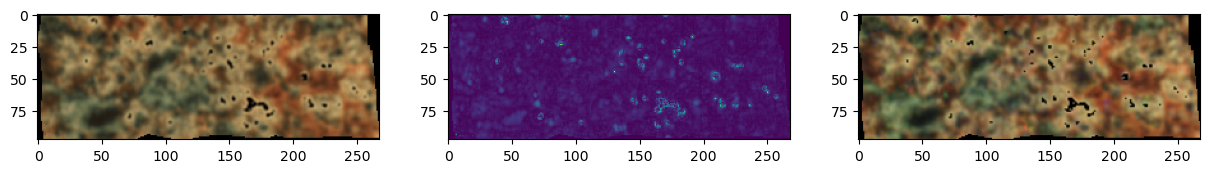

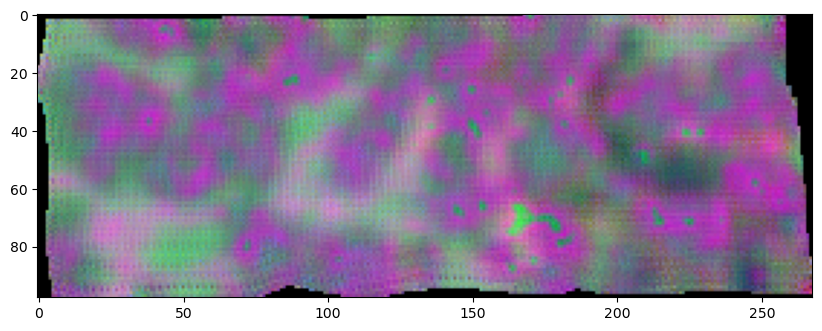

In [14]:
vis_model(f'models/FusionModel-z-3-c-1-h-256-d-4-r-5.pt')

(0.9784916657954454, 0.9323179125785828)


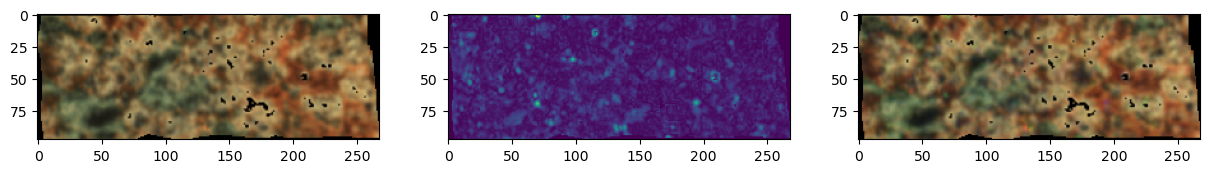

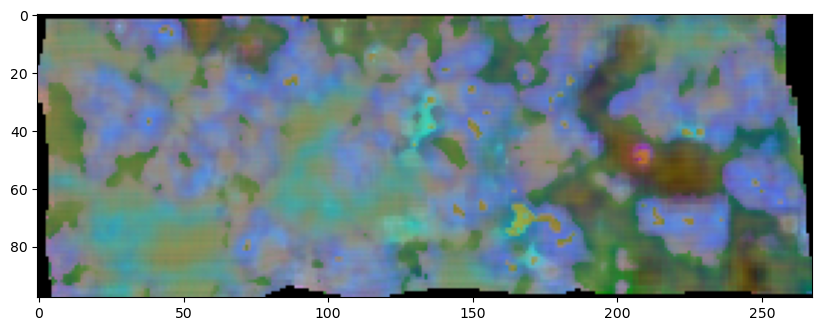

In [15]:
vis_model(f'models/NaiveFusionModel-z-3-c-1-h-256-d-4-r-5.pt')

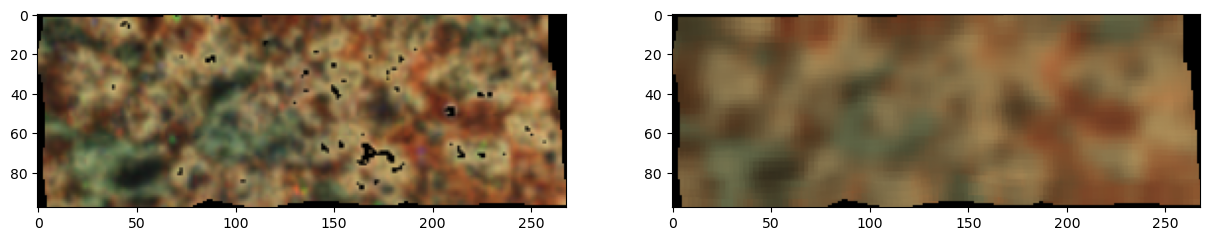

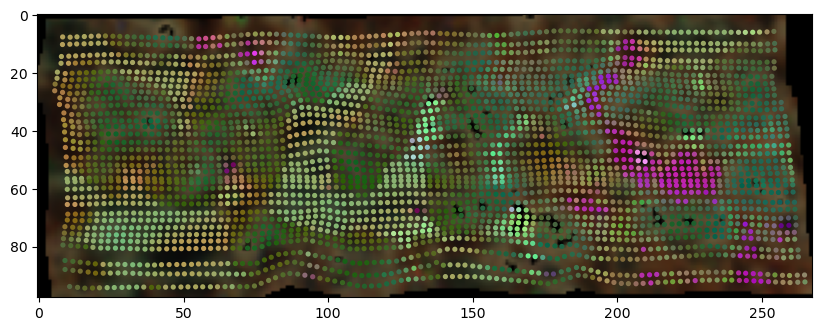

In [16]:
vis_q_model(f'models/JointVAE-z-3-c-1-h-256-d-4-r-5.pt')

In [62]:
def vis_latent_scatter(model_path,points=None,bins=250,lims=None):
    model = torch.load(model_path).eval().to(device)    
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        batch_c, batch_z = model.encode(batch_x,batch_q)
        batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())
        z.append(batch_z.detach().cpu())
        x_hat.append(batch_x_hat.detach().cpu())
        q_hat.append(batch_q_hat.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu().numpy()
    q = torch.cat(q,dim=0).detach().cpu().numpy()
    z = torch.cat(z,dim=0).detach().cpu().numpy()
    x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
    q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

    print(eval_recon(x,q,x_hat,q_hat))

    
    z = z.reshape(-1,z.shape[-1])
    from sklearn.preprocessing import StandardScaler
#     z = StandardScaler().fit_transform(z)
    
    plt.figure(figsize=(10,10))
    g = sns.histplot(x=z[:,0],y=z[:,1], bins=bins, cmap="viridis")
    if lims is not None:
        g.set(xlim=(lims[0][0], lims[0][1]))
        g.set(ylim=(lims[1][0], lims[1][1]))

    if points is not None:
        plt.scatter(points[0],points[1],c='red')
    plt.show()


(0.7865288406610489, 0.9340896531939507)


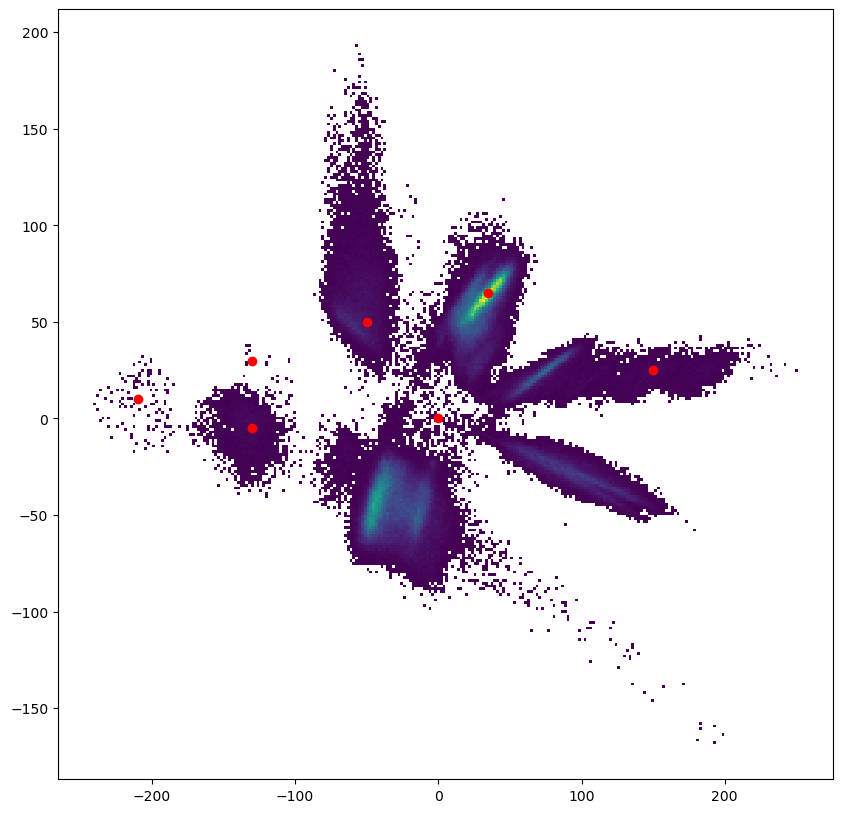

In [18]:
vis_latent_scatter(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',[[0,35,-50,-130,-210,150,-130],[0,65,50,-5,10,25,30]])


(0.9036335498094559, 0.9727266822010279)


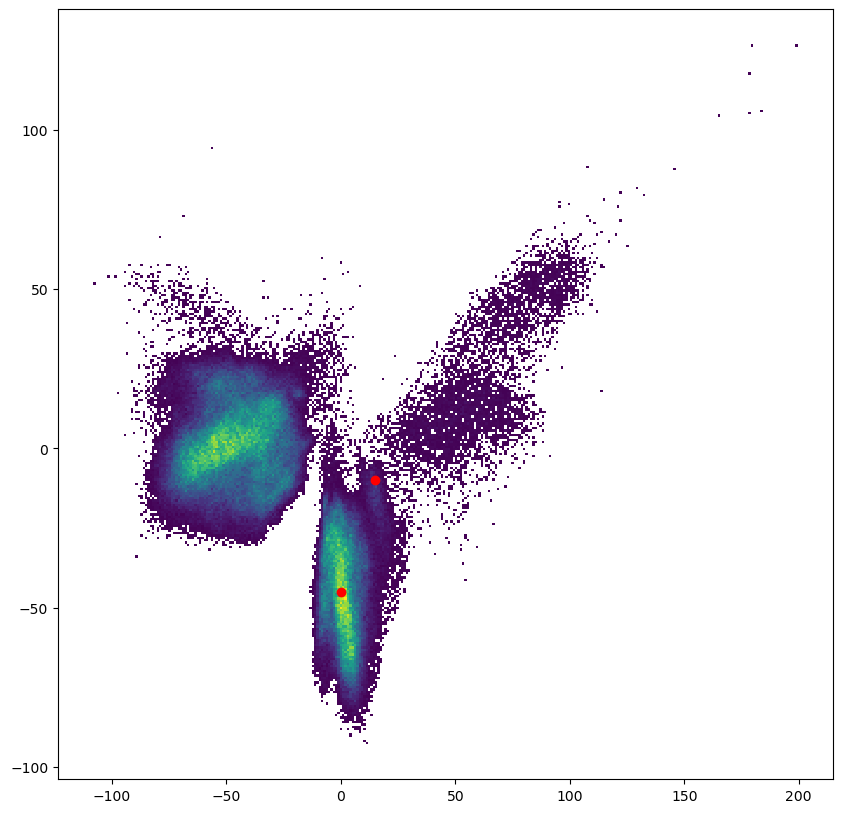

In [71]:
vis_latent_scatter(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',np.array([[15,-10],[0,-45]]).T,bins=300)


(0.9036497324705124, 0.9727222137153149)


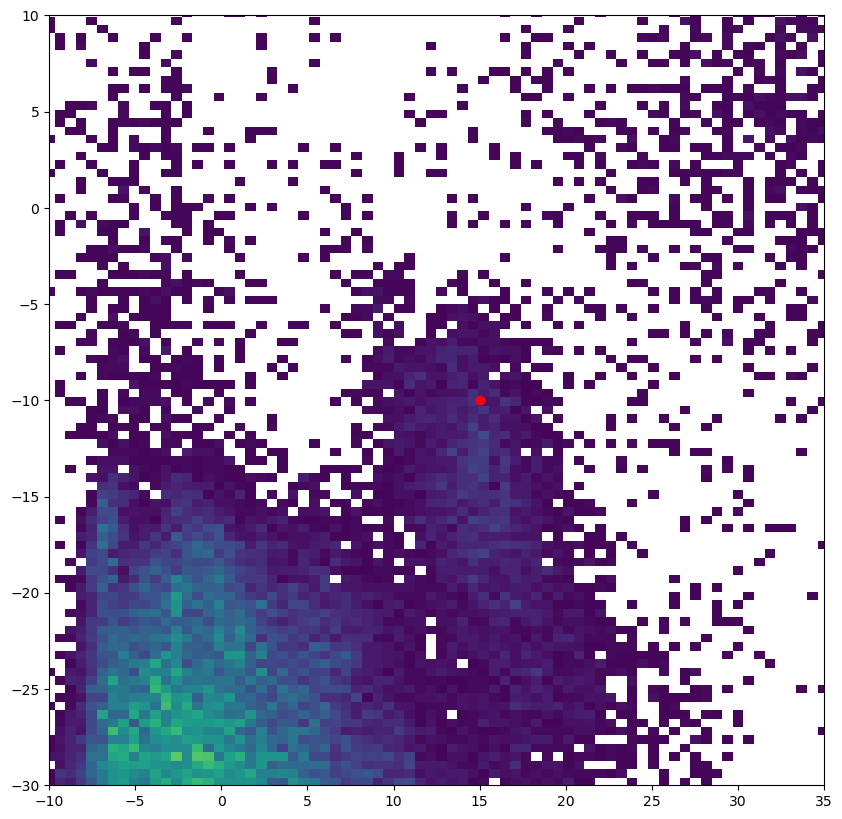

In [67]:
vis_latent_scatter(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',np.array([[15,-10]]).T,bins=500,lims=[(-10,35),(-30,10)])


(0.725035548210144, 0.8585852086544037)


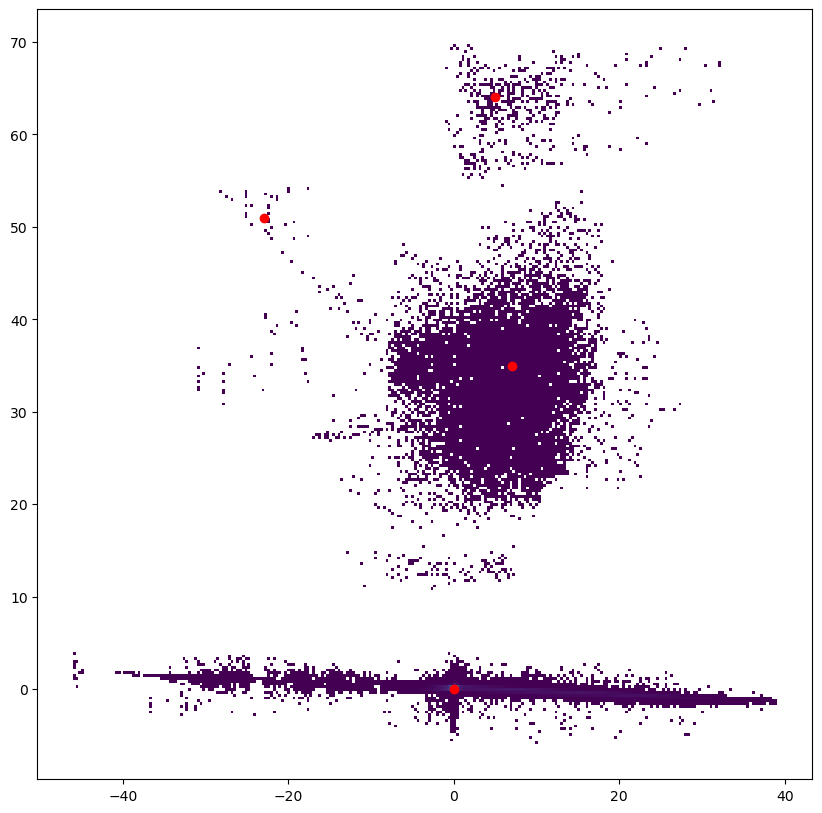

In [20]:
vis_latent_scatter(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',[[0,7,5,-23],[0,35,64,51]])

(-0.6126224994659424, 0.4629058837890625)


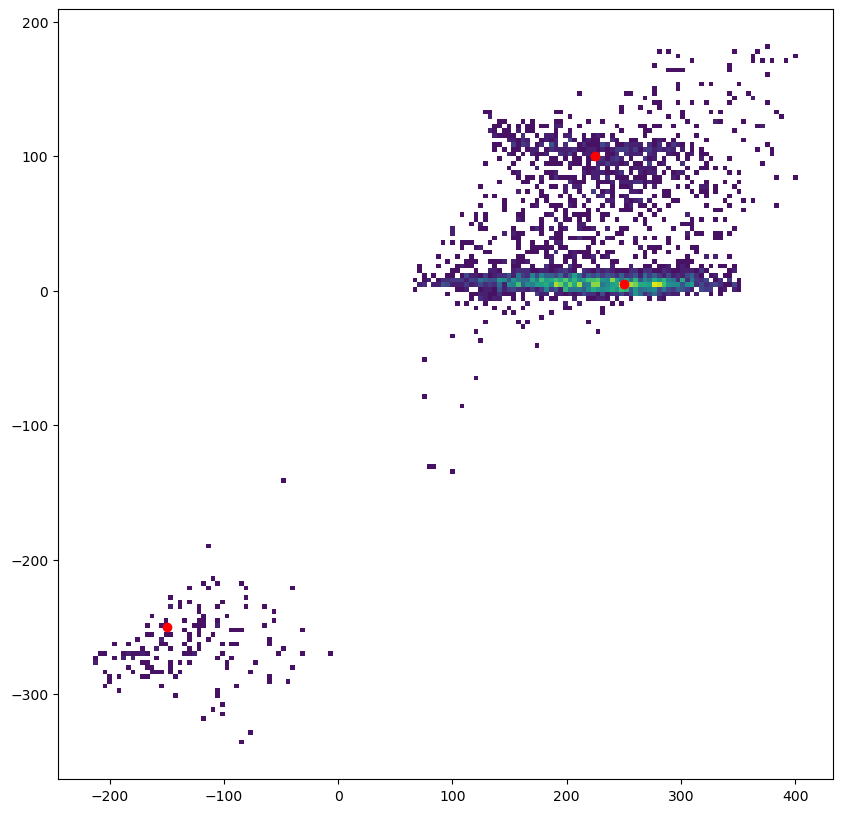

In [22]:
vis_latent_scatter(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([[250,5],[-150,-250],[225,100]]).T,bins=150,)

(-0.4400120973587036, 0.7348457872867584)


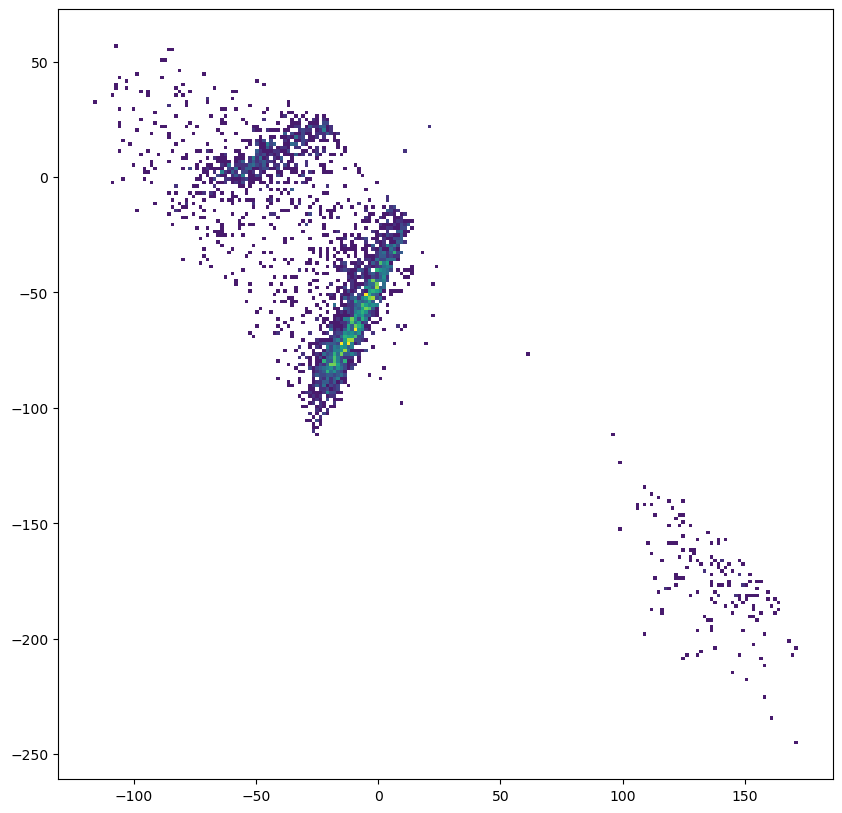

In [78]:
vis_latent_scatter(f'models/JointVAE-z-2-c-1-h-256-d-4-r-5.pt',bins=200,)

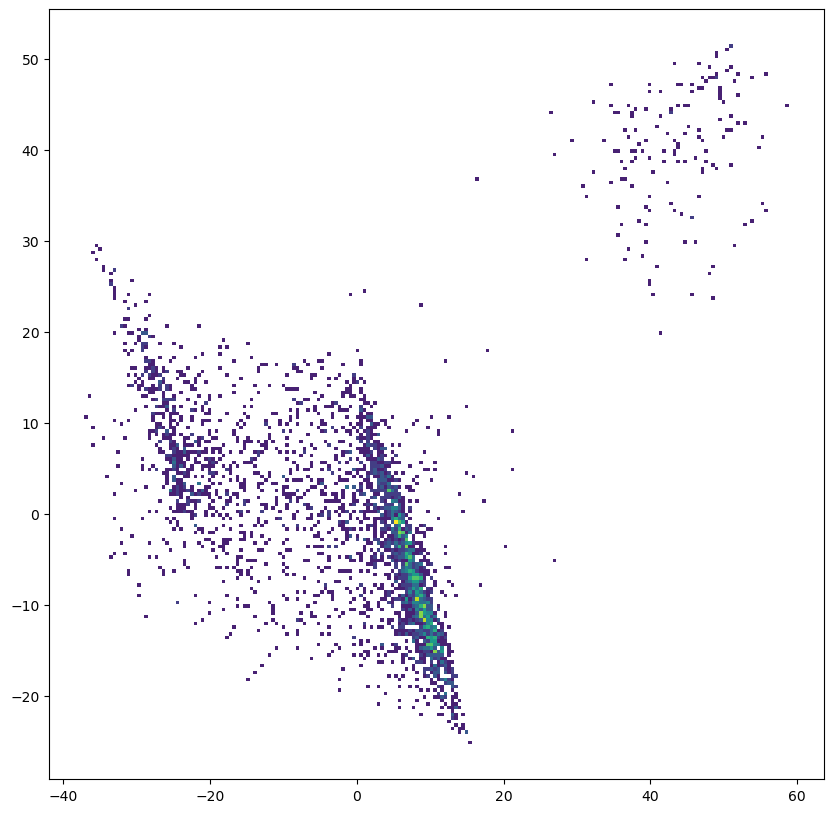

In [74]:
def vis_pca_scatter():
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu()
    q = torch.cat(q,dim=0).detach().cpu()
    
    x /= x.shape[1]*x.shape[2]/q.shape[1]

    combined_data = torch.cat((q,x.reshape((x.shape[0],-1))),1).numpy()
    pca = PCA(n_components=2)
    pca.fit(combined_data)
    z = pca.transform(combined_data)

    z = z.reshape(-1,z.shape[-1])
    from sklearn.preprocessing import StandardScaler
#   z = StandardScaler().fit_transform(z)
    plt.figure(figsize=(10,10))
    sns.histplot(x=z[:,0],y=z[:,1], bins=200, cmap="viridis")
    plt.show()

vis_pca_scatter()

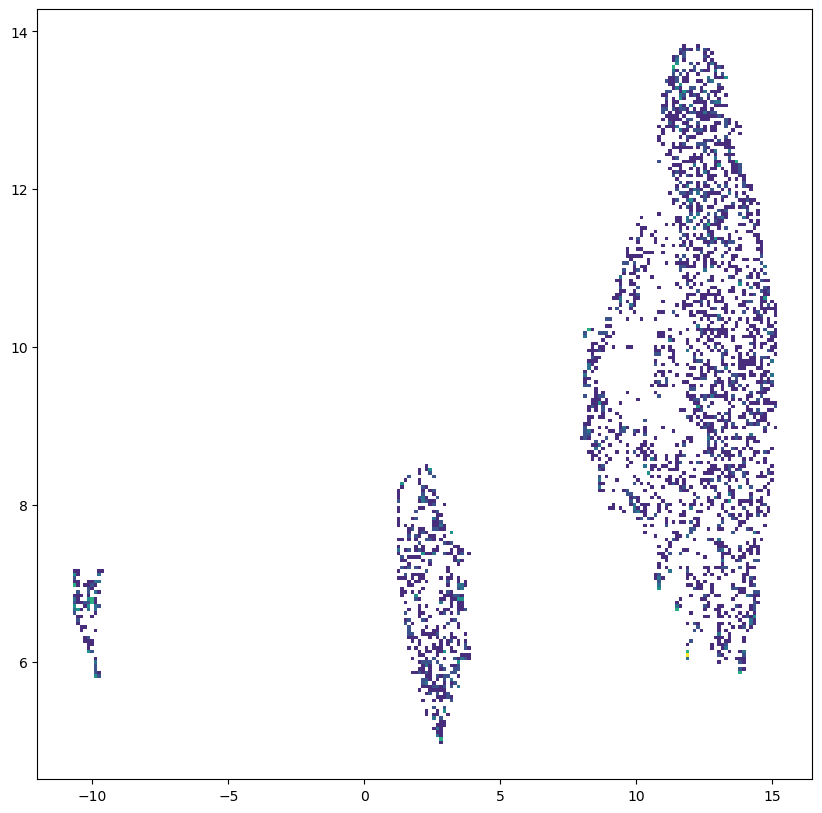

In [76]:
def vis_umap_scatter():
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu()
    q = torch.cat(q,dim=0).detach().cpu()
    
    x /= x.shape[1]*x.shape[2]/q.shape[1]

    combined_data = torch.cat((q,x.reshape((x.shape[0],-1))),1).numpy()

    umap_model = umap.UMAP(n_components=2,random_state=42)
    umap_model = umap_model.fit(combined_data) 
    z = umap_model.transform(combined_data) 

    
    plt.figure(figsize=(10,10))
    sns.histplot(x=z[:,0],y=z[:,1], bins=200, cmap="viridis")
    plt.show()

vis_umap_scatter()

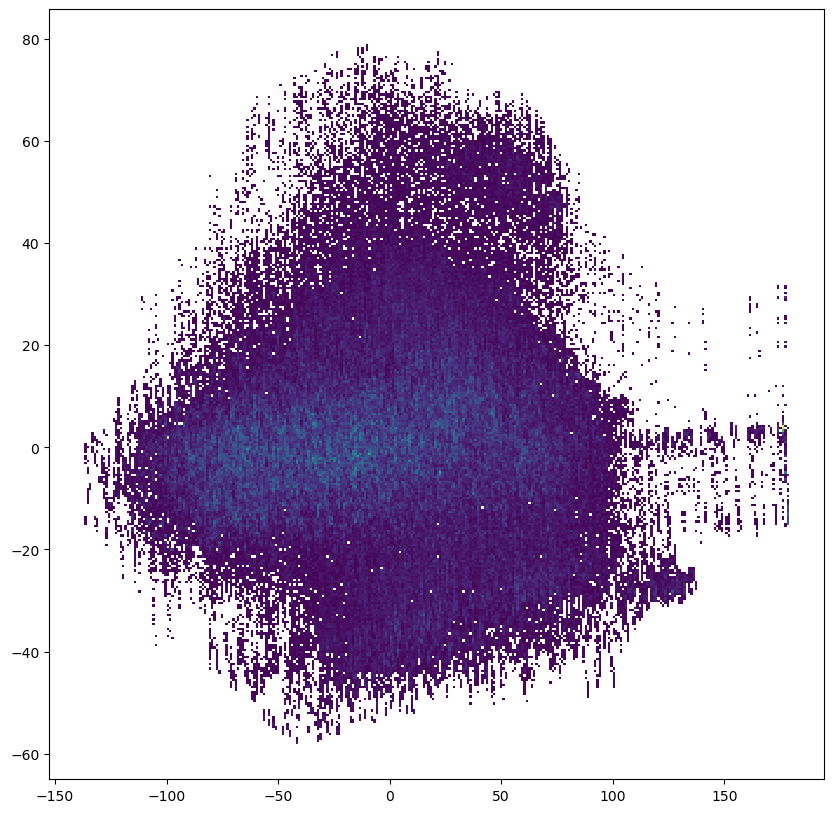

In [77]:
def vis_pca_concat_scatter():
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu()
    q = torch.cat(q,dim=0).detach().cpu()
    q_repeat = q.repeat(1,x.shape[1]).reshape(-1,q.shape[-1])

    combined_data = torch.cat((q_repeat,x.reshape((-1,x.shape[-1]))),1).numpy()
    pca = PCA(n_components=2)
    pca.fit(combined_data)
    z = pca.transform(combined_data)

    z = z.reshape(-1,z.shape[-1])
    from sklearn.preprocessing import StandardScaler
#   z = StandardScaler().fit_transform(z)
    plt.figure(figsize=(10,10))
    sns.histplot(x=z[:,0],y=z[:,1], bins=300, cmap="viridis")
    plt.show()

vis_pca_concat_scatter()

/home/austin/.conda/envs/JPLEnv/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.                  
  warnings.warn(


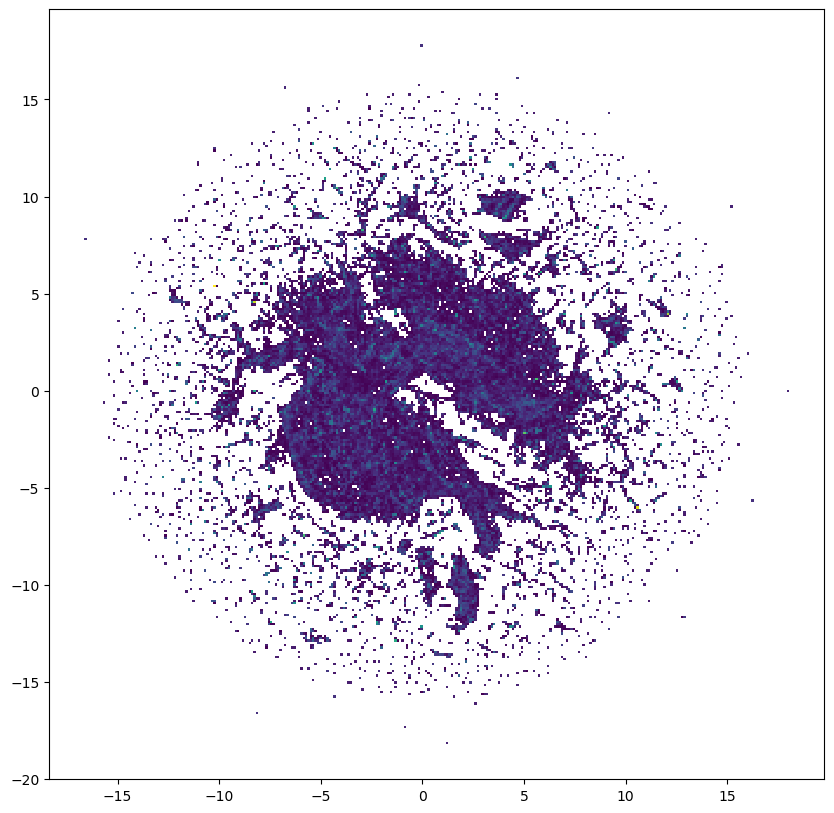

In [27]:
def vis_umap_concat_scatter():
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu()
    q = torch.cat(q,dim=0).detach().cpu()
    q_repeat = q.repeat(1,x.shape[1]).reshape(-1,q.shape[-1])

    combined_data = torch.cat((q_repeat,x.reshape((-1,x.shape[-1]))),1).numpy()
    umap_model = umap.UMAP(n_components=2,random_state=42)
    umap_model = umap_model.fit(combined_data) 
    z = umap_model.transform(combined_data) 

    z = z.reshape(-1,z.shape[-1])
    from sklearn.preprocessing import StandardScaler
#   z = StandardScaler().fit_transform(z)
    plt.figure(figsize=(10,10))
    sns.histplot(x=z[:,0],y=z[:,1], bins=300, cmap="viridis")
    plt.show()

vis_umap_concat_scatter()

In [28]:
def vis_model_response(model_path,latent_center,radius):
    model = torch.load(model_path).eval().to(device)    
    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//256),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        batch_c, batch_z = model.encode(batch_x,batch_q)
        batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())
        z.append(batch_z.detach().cpu())
        x_hat.append(batch_x_hat.detach().cpu())
        q_hat.append(batch_q_hat.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu().numpy()
    q = torch.cat(q,dim=0).detach().cpu().numpy()
    z = torch.cat(z,dim=0).detach().cpu().numpy()
    x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
    q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()
    
    
    cropped_img, min_i, max_i, min_j, max_j = crop_img(dataset.convert_batch_latents_to_image(x).astype(int)[:,:,:3])

    if latent_center.shape != (z.shape[2],):
        print(f'MIsmatch input latent shape {z.shape} and latent center shape {latent_center.shape}')
        
    response_z = (np.sum(np.abs((z.reshape(-1,z.shape[-1]) - latent_center)),1)).reshape((-1,1))
    response_z = (response_z < radius)+0.01
    response_z = response_z.reshape((z.shape[0],z.shape[1],1)).astype(float)
    z_img = crop_img(dataset.convert_batch_latents_to_image(response_z))[0].astype(float)
    fig, axs = plt.subplots(1,1,figsize=(10,10))

    axs.imshow(z_img)
    plt.show()


In [29]:
def vis_q_model_response(model_path,latent_center,radius):
    model = torch.load(model_path).eval().to(device)    
    x , q = [], []
    c, z = [], []
    x_hat, q_hat = [], []
    for batch_x,batch_q in tqdm(data_loader,total=1+(len(dataset)//512),leave=False):
        batch_x = batch_x.to(device)
        batch_q = batch_q.to(device)
        batch_c, batch_z = model.encode(batch_x,batch_q)
        batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
        x.append(batch_x.detach().cpu())
        q.append(batch_q.detach().cpu())
        z.append(batch_z.detach().cpu())
        x_hat.append(batch_x_hat.detach().cpu())
        q_hat.append(batch_q_hat.detach().cpu())

    x = torch.cat(x,dim=0).detach().cpu().numpy()
    q = torch.cat(q,dim=0).detach().cpu().numpy()
    z = torch.cat(z,dim=0).detach().cpu().numpy()
    x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
    q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()


    cropped_img, min_i, max_i, min_j, max_j = crop_img(dataset.convert_batch_latents_to_image(x).astype(int)[:,:,:3])

    
    fig, axs = plt.subplots(1,1,figsize=(10,10))
    axs.imshow(0.5*(cropped_img/255.0))
    xs = [dataset.pmc_map[pmc]['i']-min_j for pmc in dataset.pmc]
    ys = [dataset.pmc_map[pmc]['j']-min_i for pmc in dataset.pmc]
    
    
    
    if latent_center.shape != (z.shape[-1],):
        print(f'MIsmatch input latent shape {z.shape} and latent center shape {latent_center.shape}')
        
    response_z = (np.sum(np.abs((z.reshape(-1,z.shape[-1]) - latent_center)),1)).reshape((-1,1))
    response_z = (response_z < radius)+0.01
    response_z = response_z.reshape((z.shape[0],1)).astype(float)
        
    
    
    axs.scatter(xs,ys,alpha=0.95,c=response_z,s=7.5)


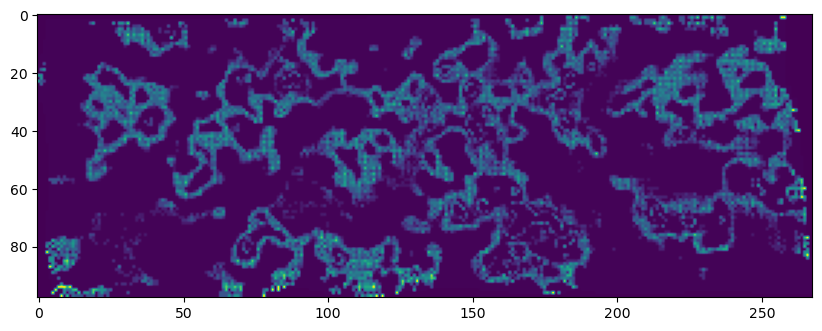

In [30]:
vis_model_response(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([35,65]),10)


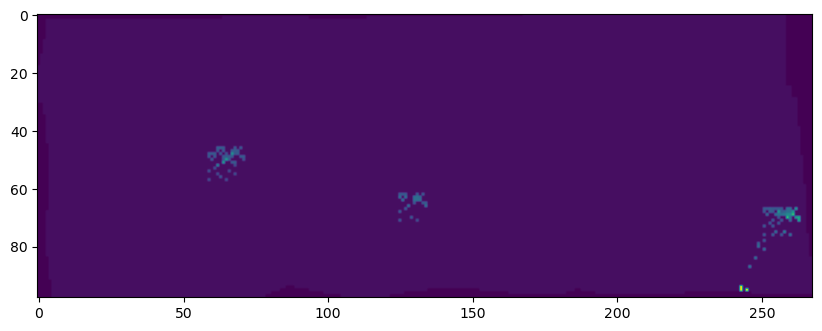

In [31]:
vis_model_response(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([-210,10]),50)


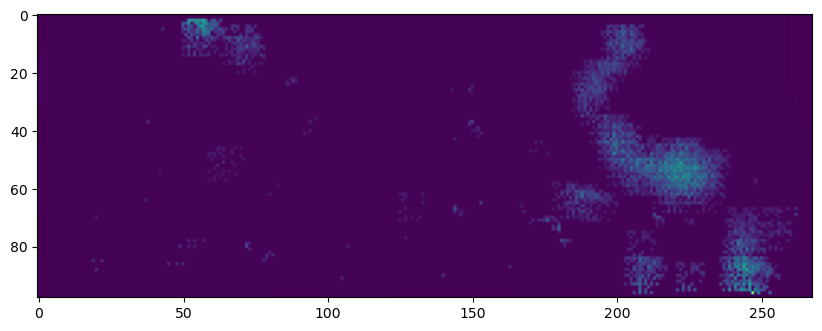

In [32]:
vis_model_response(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([-130,-5]),100)


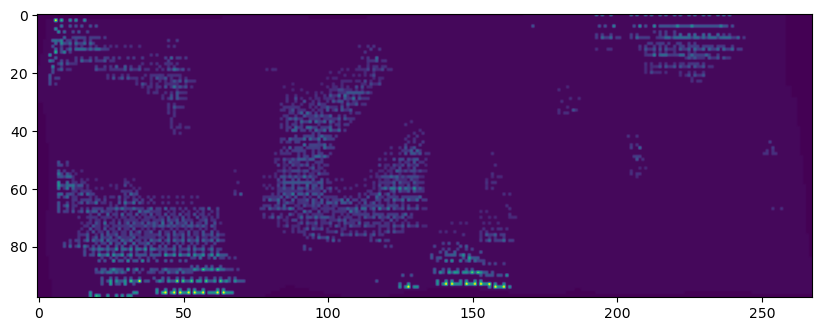

In [33]:
vis_model_response(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([150,25]),50)


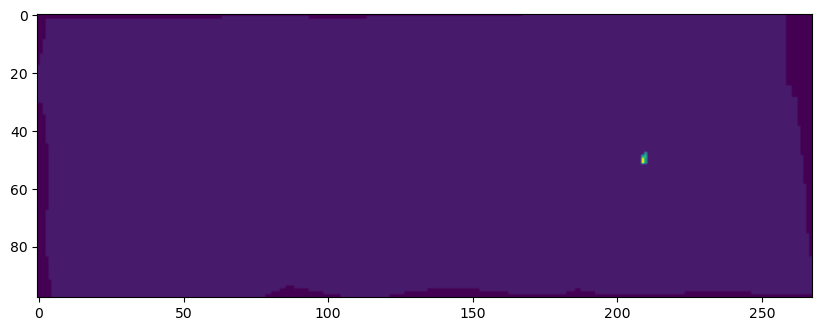

In [34]:
vis_model_response(f'models-tmp/FusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([-130,30]),10)


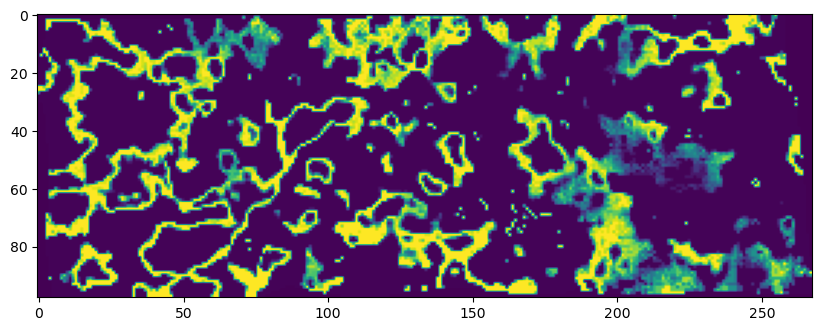

In [35]:
vis_model_response(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([0,0]),0.5)


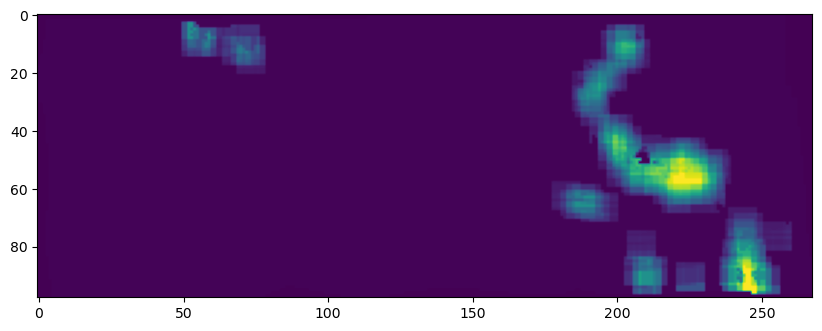

In [36]:
vis_model_response(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([7,35]),20)


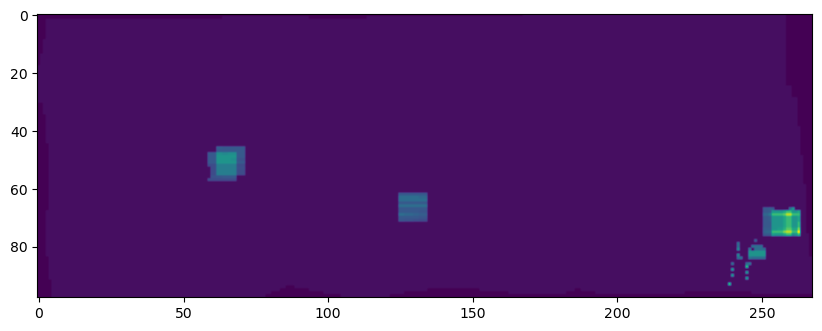

In [37]:
vis_model_response(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([5,65]),20)


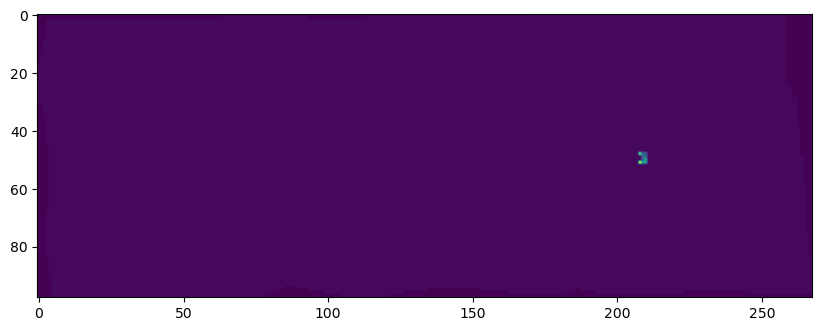

In [38]:
vis_model_response(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([-23,52]),10)


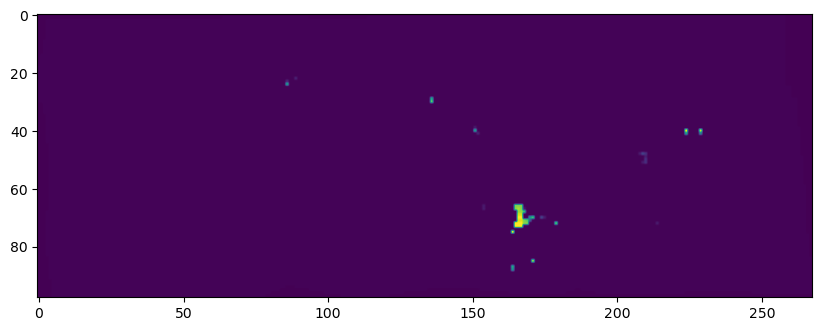

In [39]:
vis_model_response(f'models-tmp/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',np.array([-40,2]),10)


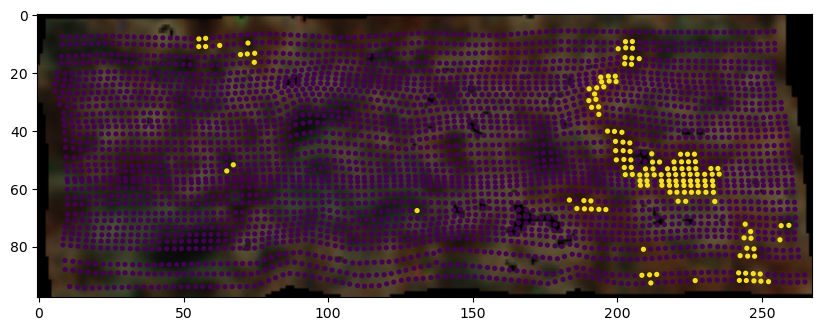

In [40]:
vis_q_model_response(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([-150,-250]),200)


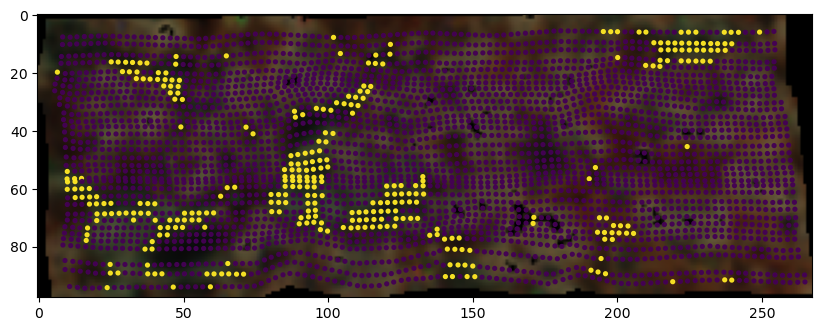

In [41]:
vis_q_model_response(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([225,100]),50)


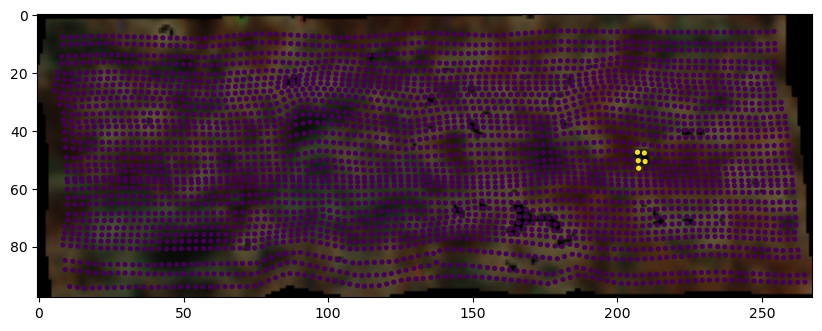

In [42]:
vis_q_model_response(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([100,-150]),100)


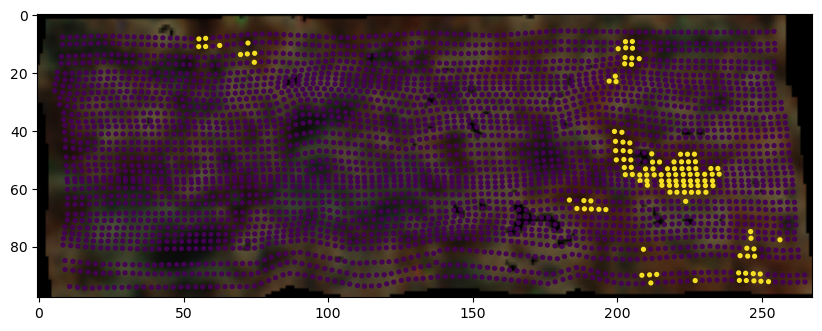

In [43]:
vis_q_model_response(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([-150,-250]),100)


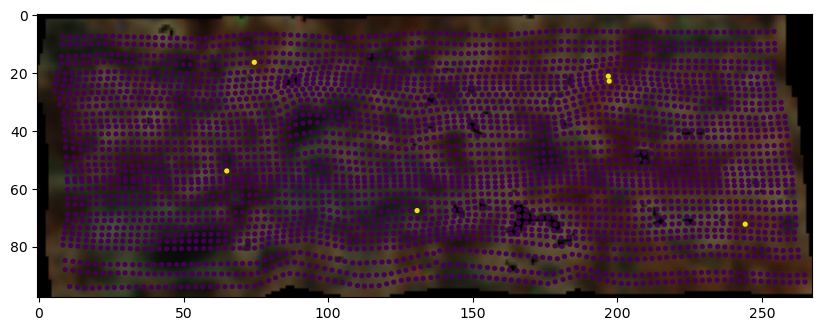

In [44]:
vis_q_model_response(f'models-tmp/JointVAE-z-2-c-1-h-64-d-16-r-5.pt',np.array([-100,-300]),20)


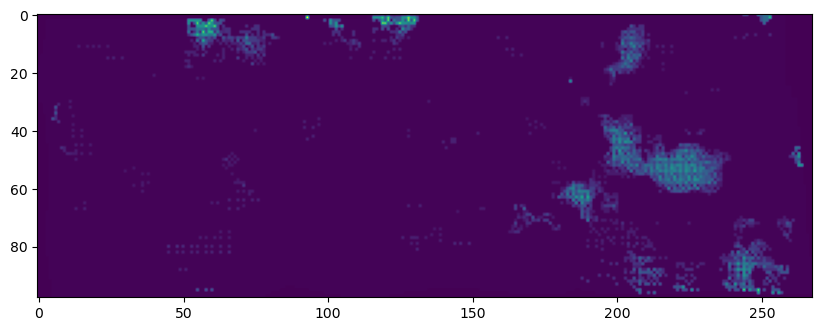

In [59]:
vis_model_response(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',np.array([15,-10]),20)


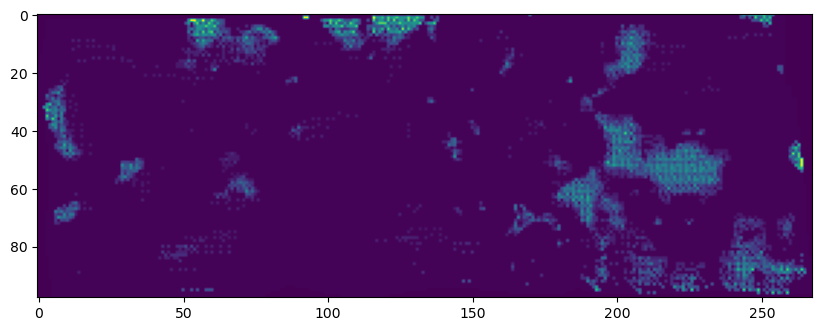

In [61]:
vis_model_response(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',np.array([15,-10]),25)


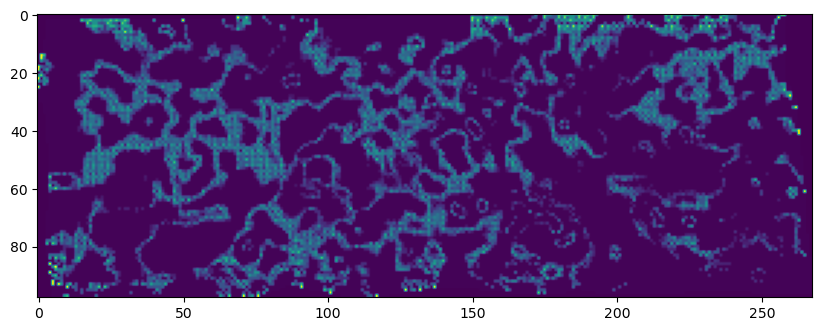

In [72]:
vis_model_response(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',np.array([0,-45]),10)
